In [2]:
import os
os.chdir('/Users/thompsong/DATA/KSC')
import glob, obspy
seedfiles = glob.glob('*.seed')

In [26]:
import numpy as np
signal_stime = obspy.UTCDateTime(2022,4,8,15,16,30)
signal_etime = obspy.UTCDateTime(2022,4,8,15,20,0)
threshold = 1.3
pretrig = 180
posttrig = pretrig
stime = signal_stime - pretrig
etime = signal_etime + posttrig
st_all = obspy.Stream()

def median_abs_signal(tr, time1, time2):
    tr2 = tr.copy()
    tr2.trim(starttime=time1, endtime=time2)
    y = np.median(np.abs(tr2.data))
    return y

def correct_data(tr):
    calib = 0
    if tr.stats.channel[1]=='D':
        if tr.id == 'FL.BCHH3.10.HDF': # Chaparral
            calib = 8e5 # counts/Pa at 1V
        else: # infraBSU 0.5inch
            calib = 720 # counts/Pa at 1V
    else: # seismic
        calib = 3e8 # counts/m/s
    tr.data /= calib
        
    
for seedfile in seedfiles:
    st = obspy.read(seedfile)
    st.detrend()
    st.filter('highpass', freq=0.05)
    
    for tr in st:
        ynoise = median_abs_signal(tr, stime, signal_stime-pretrig/6)
        ysignal = median_abs_signal(tr, signal_stime, signal_etime)
        if ysignal/ynoise > threshold:
            correct_data(tr)
            st_all.append(tr)
st_all.trim(starttime=stime, endtime=etime)            

<ipython-input-26-57b9733c1c69>:37: RuntimeWarning: invalid value encountered in double_scalars
  if ysignal/ynoise > threshold:


19 Trace(s) in Stream:
FL.S39A3.00.HDF | 2022-04-08T15:13:30.000000Z - 2022-04-08T15:23:00.000000Z | 100.0 Hz, 57001 samples
FL.S39A3.10.HDF | 2022-04-08T15:13:30.000000Z - 2022-04-08T15:23:00.000000Z | 100.0 Hz, 57001 samples
FL.BCHH2.10.HD8 | 2022-04-08T15:13:30.000000Z - 2022-04-08T15:23:00.000000Z | 100.0 Hz, 57001 samples
FL.BCHH2.10.HD4 | 2022-04-08T15:13:30.000000Z - 2022-04-08T15:23:00.000000Z | 100.0 Hz, 57001 samples
FL.BCHH2.10.HD7 | 2022-04-08T15:13:30.000000Z - 2022-04-08T15:23:00.000000Z | 100.0 Hz, 57001 samples
FL.BCHH2.10.HD9 | 2022-04-08T15:13:30.000000Z - 2022-04-08T15:23:00.000000Z | 100.0 Hz, 57001 samples
FL.BCHH2.10.HD6 | 2022-04-08T15:13:30.000000Z - 2022-04-08T15:23:00.000000Z | 100.0 Hz, 57001 samples
FL.S39A2.00.HHE | 2022-04-08T15:13:30.000000Z - 2022-04-08T15:23:00.000000Z | 100.0 Hz, 57001 samples
FL.S39A2.00.HHN | 2022-04-08T15:13:30.000000Z - 2022-04-08T15:23:00.000000Z | 100.0 Hz, 57001 samples
FL.S39A2.10.HDF | 2022-04-08T15:13:30.000000Z - 2022-04-08T

In [27]:
st_all.plot(equal_scale=False, starttime=signal_stime, endtime=signal_etime, outfile='20220408151700_axiom_calibrated.pdf');    

In [38]:
for tr in st_all:
    print(tr.id, np.max(tr.data), np.min(tr.data))

FL.S39A3.00.HDF 437.308121493 -492.10020825
FL.S39A3.10.HDF 441.818097885 -497.490791406
FL.BCHH2.10.HD8 32.4595609368 -27.5102293535
FL.BCHH2.10.HD4 37.2385664233 -33.0705274332
FL.BCHH2.10.HD7 32.9645312214 -27.8739949096
FL.BCHH2.10.HD9 27.5128346234 -32.4476230871
FL.BCHH2.10.HD6 34.0362193512 -34.5845143767
FL.S39A2.00.HHE 0.00230498647444 -0.00184356986179
FL.S39A2.00.HHN 0.00249938361223 -0.00184090939477
FL.S39A2.10.HDF 341.619060245 -315.884698934
FL.S39A2.00.HHZ 0.00214633641909 -0.00143122871457
FL.S39A1.00.HHE 0.0251802087977 -0.0118310233129
FL.S39A1.10.HDF 442.347421051 -563.474711243
FL.S39A1.00.HHZ 0.0195021672166 -0.0211936526342
FL.S39A1.00.HHN 0.0119582280081 -0.0243540099885
FL.S39A1.10.HD2 437.331523186 -556.714424032
FL.S39A1.10.HD3 430.757531999 -551.197028362
FL.BCHH3.10.HD2 34.5215286795 -35.4558123532
FL.BCHH3.10.HDF 23.9481443135 -23.3632640478


In [29]:
st_all.write('20220408151700_axiom.mseed')

/Users/thompsong/miniconda3/envs/AAA/lib/python3.8/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [30]:
st_all.write('20220408151700_axiom.pickle')

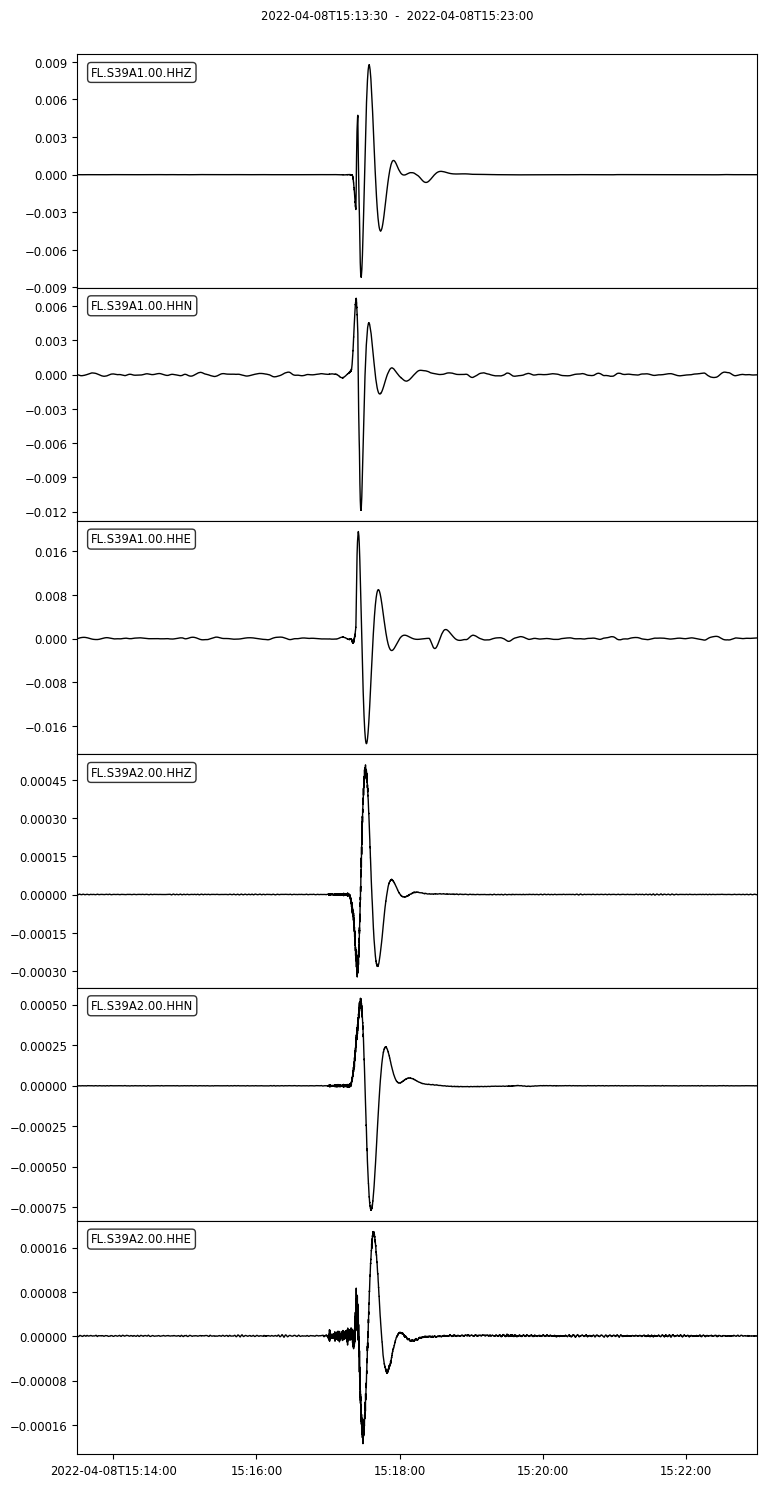

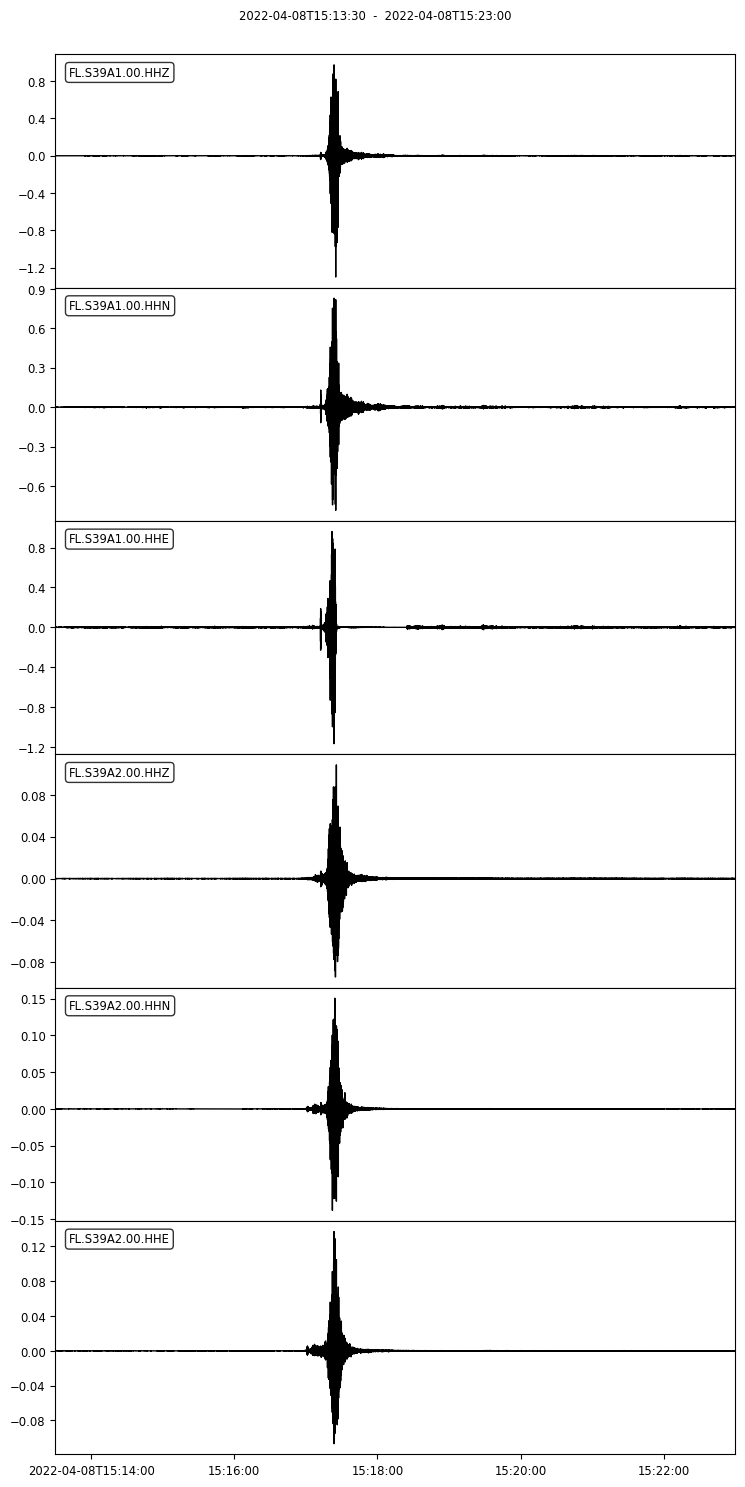

In [34]:
vel = st_all.select(channel='HH?')
disp = vel.copy().integrate()
disp.plot(equal_scale=False);
acc = vel.copy().differentiate()
acc.plot(equal_scale=False);

In [36]:
for tr in disp:
    print(tr.id, np.max(tr.data)*1000, np.max(tr.data)*1000)

FL.S39A2.00.HHE 0.188878907725 0.188878907725
FL.S39A2.00.HHN 0.540274582243 0.540274582243
FL.S39A2.00.HHZ 0.509221080723 0.509221080723
FL.S39A1.00.HHE 19.5847401736 19.5847401736
FL.S39A1.00.HHZ 8.76038293004 8.76038293004
FL.S39A1.00.HHN 6.70561643363 6.70561643363


In [39]:
for tr in acc:
    print(tr.id, np.max(tr.data)*1000, np.min(tr.data)*1000)

FL.S39A2.00.HHE 137.124623739 -106.679510206
FL.S39A2.00.HHN 150.614246792 -138.055537066
FL.S39A2.00.HHZ 108.68069391 -94.0847653997
FL.S39A1.00.HHE 961.309448052 -1167.81606693
FL.S39A1.00.HHZ 974.328829468 -1299.84939161
FL.S39A1.00.HHN 828.973239117 -784.86496318
